## *Real_Disaster or Not_Disaster tweets classification (specifically use tfidf vectorizer)*

### import required libraries

In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

#import dataset

In [2]:
tweet = pd.read_csv('train.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
tweet.shape

(7613, 5)

In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Target Class Distribution

In [6]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

c:\users\lalbabu\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

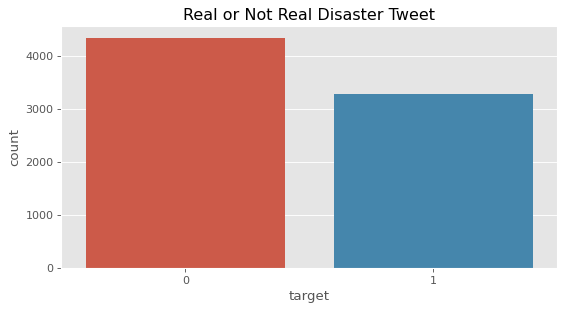

In [7]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [7]:
tweet['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

<AxesSubplot:ylabel='target'>

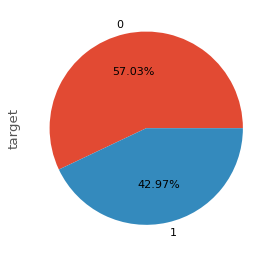

In [8]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

import preprocess_kgptalkie as kgp

In [ ]:
tweet = kgp.get_basic_features(tweet)

In [21]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


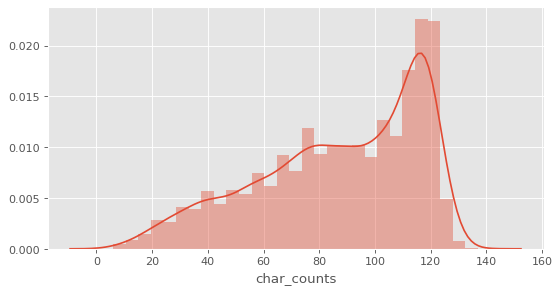

In [22]:
sns.distplot(tweet['char_counts'])

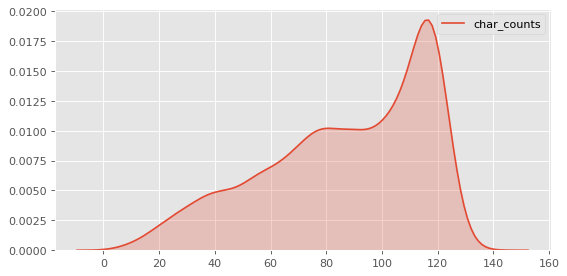

In [24]:
sns.kdeplot(tweet['char_counts'], shade=True)

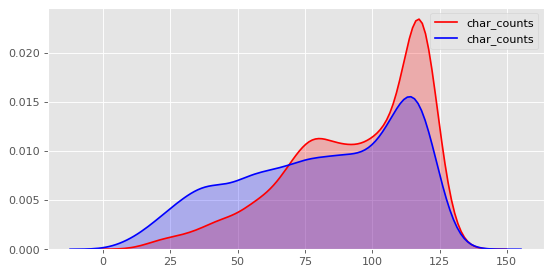

In [32]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

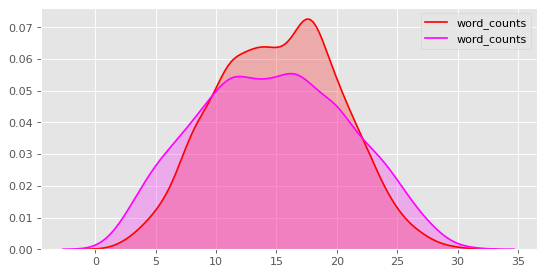

In [36]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


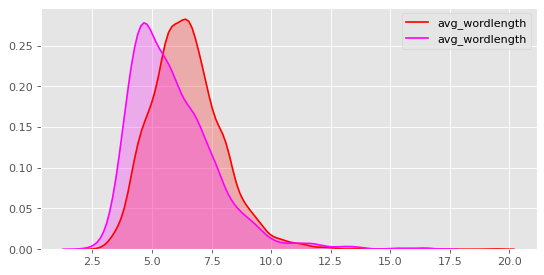

In [37]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


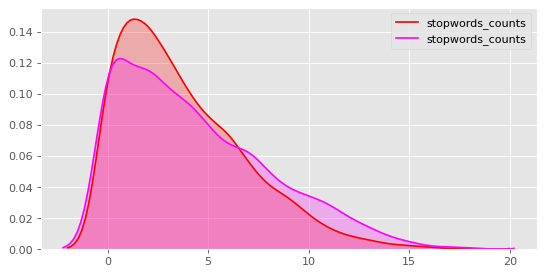

In [41]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [40]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [43]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [46]:
top20 = freqs[100:120]

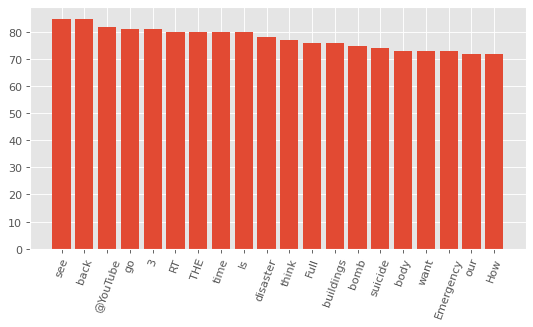

In [49]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [51]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [54]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

###  Data Cleaning

In [55]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [56]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [58]:
tweet.head()['text']

0    oyour deeds are the reason of this earetweethq...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evasee yoyouation...
4    jyoust got sent this photo from ryouby alaska ...
Name: text, dtype: object

In [64]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'heighttpt the in a of to and is i on for see at iss by from it that with not yoyou afeatyouringer this fire are was se as have my over news heighttpostscripointt youp more via thisaster an were be poli get syoui seeide california has no people evasee who minister do byout when so been intelligence like killed oyout jyoust will 2 hiroshima love than fires storm crash familthat we now train offi into ressee aaboyout s emergency yoyour bomb byouildings there all am two what mh370 attack nyouclear they time video wildfire new accident eyouropean prime learnedl one bombing noretweethern how byourning lexampleionnaires dead good me bomber pi homes some if you today car back atomi war stoday real obama isd fatal he years off collapostscripointe may forest seeal debris watch city japan malaysia yous 1 first retweet man or mass latest water near severe had confirmed earetweethqyouake thoyoughse sentral foyound life oil dthat floods world 70 spill down army apagesli servi younder home warning t

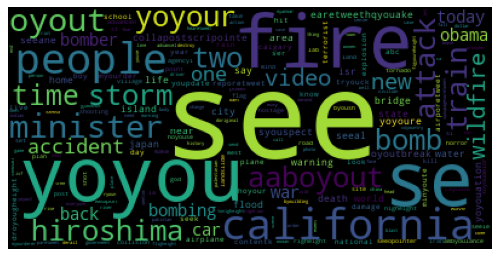

In [65]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [68]:
text = tweet['text']
y = tweet['target']

In [69]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [70]:
X.shape

(7613, 23333)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [79]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print()
    print('Classification Report')
    print(classification_report(y_test, y_pred))

In [80]:
from sklearn.svm import LinearSVC

In [81]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

